# Faster R CNN Object Detection for localization and classification of thoracic abnormalities 

!sudo apt-get update
!apt-cache search libgl
!sudo apt-get install libgl1-mesa-glx -y

## 2. Import libraries

In [1]:
# Basic Libraries
import os
import random
import re
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import warnings
warnings.filterwarnings("ignore")

# Visualization
from matplotlib import pyplot as plt
from matplotlib import gridspec
from PIL import Image
import cv2

# PyTorch
import torch
import torch.nn as nn
import torch.distributed as dist
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.utils.data.distributed import DistributedSampler
import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# Albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# tqdm for progress bars
from tqdm.autonotebook import tqdm
from tqdm.notebook import tqdm as notebook_tqdm

# sklearn
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# PyCocoTools
#!pip install pycocotools
from pycocotools.coco import COCO

# Grad-CAM
#!pip install grad-cam
from pytorch_grad_cam import EigenCAM, AblationCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image

# Ensemble Boxes
#!pip install ensemble_boxes
from ensemble_boxes import *

# mAP Calculation
#!pip install map_boxes
from map_boxes import mean_average_precision_for_boxes

# Glob for file handling
from glob import glob
import json
import itertools

In [2]:
# DETR FUCNTIONS FOR LOSS
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion

# albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

# Glob
from glob import glob

# ensembling 
#!pip install ensemble_boxes
from tqdm.autonotebook import tqdm
from ensemble_boxes import *

# mAP
#!pip install map_boxes
from map_boxes import mean_average_precision_for_boxes

import ast
from warnings import warn
from functools import partial

!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py

In [3]:
from engine import evaluate

## Def normalize_bboxes、denormalize_bboxes

In [4]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## 4. Creating Image Dataset class


In [5]:
def get_train_transforms_faster():
    return A.Compose([
        A.ToGray(p=0.01),
        #A.HorizontalFlip(p=0.5),
        #A.RandomBrightnessContrast(p=0.2),  
        ToTensorV2()
    ], 
    bbox_params=A.BboxParams(format='pascal_voc', min_area=0, min_visibility=0, label_fields=['labels']))


def get_valid_transforms_faster():
    return A.Compose([
        ToTensorV2()
    ],
    bbox_params=A.BboxParams(format='pascal_voc', min_area=0, min_visibility=0, label_fields=['labels']))

In [6]:
def get_train_transforms_detr():
    # image augmentations for the training set
    return A.Compose([A.ToGray(p=0.01),
                      #A.Cutout(num_holes=10, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
                      ToTensorV2(p=1.0)],
                      p=1.0,
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

def get_valid_transforms_detr():
    # image augmentations for the validation set
    return A.Compose([ToTensorV2(p=1.0)], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

## 5. Faster R C-CNN model initialization

In [7]:
def fasterrcnn(num_classes):
    model = models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1') 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = None
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [8]:
import torch.nn.functional as F
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        
        for param in self.model.parameters():
            param.requires_grad = True


        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes+1)
        self.model.num_queries = self.num_queries
        
    def forward(self,images):
        return self.model(images)

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [10]:
n_folds = 5
seed = 42
num_classes = 15
num_queries = 2
null_class_coef = 0.2
BATCH_SIZE = 16
EPOCHS = 1

## 8. Prediction

### 8.1 Load model

After training the model, comment the line "model = run(fold=0)", and load the model to run the predictions in the test set 

In [11]:
def load_model_faster():
    ## Loading a model
    num_classes = 15
    model = fasterrcnn(num_classes=num_classes)
    best_ckpt = torch.load("fasterrcnncheckpoint.pth", map_location=torch.device('cpu'))
    model.load_state_dict(best_ckpt)
    return model

In [12]:
def load_model_detr():
    ## Loading a model
    num_classes = 15
    num_queries = 2
    model = DETRModel(num_classes=num_classes,num_queries=num_queries)
    model.load_state_dict(torch.load("/home/ttban9527/detr_model.pth", map_location=torch.device('cpu')))
    return model

In [13]:
class VinDatasetFromCSV:
    def __init__(self, csv_path, image_dir, transforms=None):
        """
        Args:
            csv_path (str): CSV 文件的路徑，包含圖像 ID 和標註信息。
            image_dir (str): 圖像保存的目錄。
            transforms (callable, optional): 數據增強和處理操作。
        """
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 從 CSV 獲取數據行
        row = self.data.iloc[idx]
        image_id = int(row["image_id"])
        boxes = eval(row["boxes"])  # 從字符串轉換為列表
        labels = eval(row["labels"])  # 從字符串轉換為列表
        area = eval(row["area"])  # 從字符串轉換為列表
        iscrowd = eval(row["iscrowd"])  # 從字符串轉換為列表

        # 加載對抗圖像
        img_path = os.path.join(self.image_dir, f"{image_id}.png")
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if image is None:
            raise ValueError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        # 構建 target 字典
        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
            "image_id": int(image_id),
            "area": torch.as_tensor(area, dtype=torch.float32),
            "iscrowd": torch.as_tensor(iscrowd, dtype=torch.int64),
        }

        # 應用 transforms
        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, labels=labels)
            image = transformed["image"]
            target["boxes"] = torch.as_tensor(transformed["bboxes"], dtype=torch.float32)
            target["labels"] = torch.as_tensor(transformed["labels"], dtype=torch.int64)

        return image, target

In [14]:
class adv_VinDataset(Dataset):
    def __init__(self, path, transforms=None):
        self.df = pd.read_csv(path + "annotations.csv")
        self.path = path
        self.df["boxes"] = self.df["boxes"].apply(ast.literal_eval)
        self.df["labels"] = self.df["labels"].apply(ast.literal_eval)
        self.image_ids = self.df["image_id"].tolist()
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        record = self.df.iloc[index]

        # 讀取圖片
        image = cv2.imread(f'{self.path}/{image_id}.png', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        # 讀取標註
        boxes = np.array(record["boxes"], dtype=np.float32)
        labels = np.array(record["labels"], dtype=np.int64)

        # 確保 boxes 是 2D
        if boxes.ndim == 1:
            boxes = np.expand_dims(boxes, axis=0)
            labels = np.expand_dims(labels, axis=0)

        # 確保 labels 為 list
        sample = {
            'image': image,
            'bboxes': boxes.tolist(),
            'labels': labels.tolist()
        }

        # 應用 Albumentations 轉換
        if self.transforms:
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']

        # 確保 bounding box 格式正確
        boxes = np.array(boxes, dtype=np.float32)
        labels = np.array(labels, dtype=np.int64)

        # 確保 PyTorch 不會出錯
        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.long),
            "image_id": torch.tensor([index])
        }

        # 確保 image 是 torch.Tensor 並歸一化
        if not isinstance(image, torch.Tensor):
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        image = image / 255.0

        return image, target, image_id

In [15]:
def safe_matrix_mult(Y, chunk_size=128):
    batch_size = Y.shape[0]
    L = torch.zeros((batch_size, batch_size), device=Y.device, dtype=Y.dtype)  # 初始化結果

    for i in range(0, batch_size, chunk_size):
        i_end = min(i + chunk_size, batch_size)
        for j in range(0, batch_size, chunk_size):
            j_end = min(j + chunk_size, batch_size)
            L[i:i_end, j:j_end] = Y[i:i_end] @ Y[j:j_end].t()

    return L

In [16]:
from mpl_toolkits import axes_grid1
import matplotlib.pyplot as plt
from typing import List, Dict
from torchvision.models.detection.image_list import ImageList
from collections import OrderedDict

def add_colorbar(im, aspect=10, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

class CKA:
    def __init__(self,
                 model1: nn.Module,
                 model2: nn.Module,
                 model1_name: str = None,
                 model2_name: str = None,
                 model1_layers: List[str] = None,
                 model2_layers: List[str] = None,
                 device: str ='cpu'):
        """

        :param model1: (nn.Module) Neural Network 1
        :param model2: (nn.Module) Neural Network 2
        :param model1_name: (str) Name of model 1
        :param model2_name: (str) Name of model 2
        :param model1_layers: (List) List of layers to extract features from
        :param model2_layers: (List) List of layers to extract features from
        :param device: Device to run the model
        """

        self.model1 = model1
        self.model2 = model2

        self.device = device
        
        # Initialize K and L matrices to None
        self.K_matrices = None
        self.L_matrices = None

        self.model1_info = {}
        self.model2_info = {}

        if model1_name is None:
            self.model1_info['Name'] = model1.__repr__().split('(')[0]
        else:
            self.model1_info['Name'] = model1_name

        if model2_name is None:
            self.model2_info['Name'] = model2.__repr__().split('(')[0]
        else:
            self.model2_info['Name'] = model2_name

        if self.model1_info['Name'] == self.model2_info['Name']:
            warn(f"Both model have identical names - {self.model2_info['Name']}. " \
                 "It may cause confusion when interpreting the results. " \
                 "Consider giving unique names to the models :)")

        self.model1_info['Layers'] = []
        self.model2_info['Layers'] = []

        self.model1_features = {}
        self.model2_features = {}

        if len(list(model1.modules())) > 150 and model1_layers is None:
            warn("Model 1 seems to have a lot of layers. " \
                 "Consider giving a list of layers whose features you are concerned with " \
                 "through the 'model1_layers' parameter. Your CPU/GPU will thank you :)")

        self.model1_layers = model1_layers

        if len(list(model2.modules())) > 150 and model2_layers is None:
            warn("Model 2 seems to have a lot of layers. " \
                 "Consider giving a list of layers whose features you are concerned with " \
                 "through the 'model2_layers' parameter. Your CPU/GPU will thank you :)")

        self.model2_layers = model2_layers

        self._insert_hooks()
        self.model1 = self.model1.to(self.device)
        self.model2 = self.model2.to(self.device)

        self.model1.eval()
        self.model2.eval()

    def _log_layer(self,
                   model: str,
                   name: str,
                   layer: nn.Module,
                   inp: torch.Tensor,
                   out: torch.Tensor):
        
        if model == "model1":
            self.model1_features[name] = out

        elif model == "model2":
            self.model2_features[name] = out

        else:
            raise RuntimeError("Unknown model name for _log_layer.")

    def _insert_hooks(self):
        # Model 1
        for name, layer in self.model1.named_modules():
            if self.model1_layers is not None:
                if name in self.model1_layers:
                    self.model1_info['Layers'] += [name]
                    layer.register_forward_hook(partial(self._log_layer, "model1", name))
            else:
                self.model1_info['Layers'] += [name]
                layer.register_forward_hook(partial(self._log_layer, "model1", name))

        # Model 2
        for name, layer in self.model2.named_modules():
            if self.model2_layers is not None:
                if name in self.model2_layers:
                    self.model2_info['Layers'] += [name]
                    layer.register_forward_hook(partial(self._log_layer, "model2", name))
            else:

                self.model2_info['Layers'] += [name]
                layer.register_forward_hook(partial(self._log_layer, "model2", name))

    def _HSIC(self, K, L):
        """
        Computes the unbiased estimate of HSIC metric.

        Reference: https://arxiv.org/pdf/2010.15327.pdf Eq (3)
        """
        N = K.shape[0]
        ones = torch.ones(N, 1).to(self.device)
        #ones = torch.ones(N, 1, dtype=torch.float16, device=self.device)
        result = torch.trace(K @ L)
        result += ((ones.t() @ K @ ones @ ones.t() @ L @ ones) / ((N - 1) * (N - 2))).item()
        result -= ((ones.t() @ K @ L @ ones) * 2 / (N - 2)).item()
        return (1 / (N * (N - 3)) * result).item()

    def compare(self,
                dataloader1: DataLoader,
                dataloader2: DataLoader = None) -> None:
        """
        Computes the feature similarity between the models on the
        given datasets.
        :param dataloader1: (DataLoader)
        :param dataloader2: (DataLoader) If given, model 2 will run on this
                            dataset. (default = None)
        """

        if dataloader2 is None:
            warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")
            dataloader2 = dataloader1

        self.model1_info['Dataset'] = dataloader1.dataset.__repr__().split('\n')[0]
        self.model2_info['Dataset'] = dataloader2.dataset.__repr__().split('\n')[0]

        N = len(self.model1_layers)
        M = len(self.model2_layers)

        self.hsic_matrix = torch.zeros(N, M, 3)

        num_batches = min(len(dataloader1), len(dataloader2))
        
        layer_names = set()

        for (x1, *_), (x2, *_) in tqdm(zip(dataloader1, dataloader2), desc="| Comparing features |", total=num_batches):
            
            x1 = torch.stack([image.to(self.device) for image in x1])
            x2 = torch.stack([image.to(self.device) for image in x2])
            
            self.model1_features = {}
            self.model2_features = {}
            
            _ = self.model1(x1)
            _ = self.model2(x2)

            for i, (name1, feat1) in enumerate(self.model1_features.items()):
                layer_names.add(name1)
                #print(f"feat1 type: {type(feat1)}")
                if isinstance(feat1, tuple):
                    feat1 = feat1[0]  # 取出 ImageList (避免選到 None)

                # 如果 feat1 是 ImageList，取出 .tensors
                if isinstance(feat1, torchvision.models.detection.image_list.ImageList):
                    feat1 = feat1.tensors
                
                if isinstance(feat1, OrderedDict):
                    feat1 = feat1["3"]
                
                if isinstance(feat1, list):
                    feat1 = feat1[3]
                        
                # 確保 feat1 是 Tensor
                if not isinstance(feat1, torch.Tensor):
                    raise ValueError(f"feat1 is not a Tensor after processing: {type(feat1)}")
                    
                X = feat1.flatten(1)
                K = X @ X.t()
                K.fill_diagonal_(0.0)
                self.hsic_matrix[i, :, 0] += self._HSIC(K, K) / num_batches

                for j, (name2, feat2) in enumerate(self.model2_features.items()):
                    
                    #print(f"feat2 type: {type(feat2)}")
                    if isinstance(feat2, tuple):
                        feat2 = feat2[0]  # 取出 ImageList (避免選到 None)

                    # 如果 feat2 是 ImageList，取出 .tensors
                    if isinstance(feat2, torchvision.models.detection.image_list.ImageList):
                        feat2 = feat2.tensors
                    
                    if isinstance(feat2, OrderedDict):
                        feat2 = feat2["3"]
                    
                    if isinstance(feat2, list):
                        feat2 = feat2[3]
                        
                    # 確保 feat2 是 Tensor
                    if not isinstance(feat2, torch.Tensor):
                        raise ValueError(f"feat2 is not a Tensor after processing: {type(feat2)}")
                        
                    Y = feat2.flatten(1)
                    L = Y @ Y.t()
                    L.fill_diagonal_(0)

                    assert K.shape == L.shape, f"Feature shape mismatch! {K.shape}, {L.shape}"
                    
                    if torch.all(K == 0) or torch.all(L == 0):
                        print(f"Zero kernel matrix at layer {i}, {j}!")

                    self.hsic_matrix[i, j, 1] += self._HSIC(K, L) / num_batches
                    self.hsic_matrix[i, j, 2] += self._HSIC(L, L) / num_batches
        
        hsic_KK = self.hsic_matrix[:, :, 0]
        hsic_KL = self.hsic_matrix[:, :, 1]
        hsic_LL = self.hsic_matrix[:, :, 2]
        
        self.hsic_matrix = self.hsic_matrix[:, :, 1] / (self.hsic_matrix[:, :, 0].sqrt() * self.hsic_matrix[:, :, 2].sqrt())
        
        nan_count = torch.isnan(self.hsic_matrix).sum().item()
        if nan_count > 0:
            print(f"HSIC computation resulted in {nan_count} NaNs.")
            nan_indices = torch.isnan(self.hsic_matrix).nonzero(as_tuple=True)
            for idx in zip(*nan_indices):
                i, j = idx
                print(f"NaN at layer {i}, {j} - Values before normalization:")
                print(f"Model1 Layer: {self.model1_layers[idx[0]]}, Model2 Layer: {self.model2_layers[idx[1]]}")
                print(f"hsic_KK[{i}, {j}]: {hsic_KK[i, j]}")
                print(f"hsic_KL[{i}, {j}]: {hsic_KL[i, j]}")
                print(f"hsic_LL[{i}, {j}]: {hsic_LL[i, j]}")
                    
                
        return layer_names
        

    def export(self) -> Dict:
        """
        Exports the CKA data along with the respective model layer names.
        :return:
        """
        return {
            "model1_name": self.model1_info['Name'],
            "model2_name": self.model2_info['Name'],
            "CKA": self.hsic_matrix,
            "model1_layers": self.model1_info['Layers'],
            "model2_layers": self.model2_info['Layers'],
            "dataset1_name": self.model1_info['Dataset'],
            "dataset2_name": self.model2_info['Dataset'],

        }

    def plot_results(self,
                     save_path: str = None,
                     title: str = None):
        fig, ax = plt.subplots()
        im = ax.imshow(self.hsic_matrix, origin='lower', cmap='magma')
        ax.set_xlabel(f"Layers {self.model2_info['Name']}", fontsize=15)
        ax.set_ylabel(f"Layers {self.model1_info['Name']}", fontsize=15)

        if title is not None:
            ax.set_title(f"{title}", fontsize=18)
        else:
            ax.set_title(f"{self.model1_info['Name']} vs {self.model2_info['Name']}", fontsize=18)

        add_colorbar(im)
        plt.tight_layout()

        if save_path is not None:
            plt.savefig(save_path, dpi=300)

        plt.show()

In [17]:
def get_layer_names(model):
    layer_names = []
    for name, layer in model.named_modules():
        if name:  # Only append if the layer has a name
            layer_names.append(name)
    return layer_names

def get_filtered_layer_names(layer_names, keywords):
    # Filter the layer names based on whether they contain any of the keywords
    filtered_layer_names = [name for name in layer_names if any(keyword in name for keyword in keywords)]
    return filtered_layer_names

def remove_layers_with_keywords(layer_names, exclude_keywords):
    # Remove the layer names that contain any of the exclude_keywords
    return [name for name in layer_names if not any(exclude_keyword in name for exclude_keyword in exclude_keywords)]

for batch in test_data_loader_faster:
    images, targets = batch  # batch 應該是 (images, targets)
    
    # 檢查 images 的類型
    if isinstance(images, tuple):
        images = list(images)  # 轉成 list
        
    if isinstance(images, list):
        images = torch.stack(images)  # 如果 list 內部是 Tensor，轉成一個大 Tensor
        print(f"Batch size from DataLoader: {images.shape[0]}")
    
    elif isinstance(images, torch.Tensor):
        print(f"Batch size from DataLoader: {images.shape[0]}")
    
    elif isinstance(images, ImageList):
        print(f"Batch size from DataLoader: {images.tensors.shape[0]}")
    
    else:
        print(f"Unexpected images type: {type(images)}")
    
    break  # 只測試第一個 batch

In [18]:
seed_everything(seed)
device = torch.device('cuda')

model1 = load_model_faster()
model1.to(device)

model2 = load_model_detr()
model2.to(device)

csv_path = f"/home/ttban9527/PGD/fasterrcnn/valid/annotations.csv"
image_dir = f"/home/ttban9527/PGD/fasterrcnn/valid/"
    
# 創建測試數據集
test_dataset_faster = VinDatasetFromCSV(
    csv_path=csv_path,
    image_dir=image_dir,
    transforms=get_valid_transforms_faster()
)
    
# 創建數據加載器
test_data_loader_faster = DataLoader(
    test_dataset_faster,
    batch_size=20,
     shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

test_dataset_detr = adv_VinDataset("/home/ttban9527/PGD/detr/valid/", get_valid_transforms_detr())

test_data_loader_detr = DataLoader(
    test_dataset_detr,
    batch_size=25,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )

Using cache found in /home/ttban9527/.cache/torch/hub/facebookresearch_detr_main


| Comparing features |:   0%|          | 0/76 [00:00<?, ?it/s]

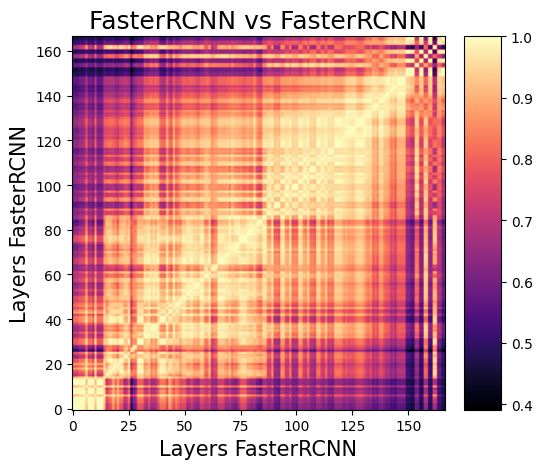

In [19]:
model1_layers = get_layer_names(model1)
model2_layers = get_layer_names(model2)

model1_layers = model1_layers[2:171]

exclude_keywords1 = []
filtered_layer_names1 = get_filtered_layer_names(model1_layers, model1_layers)
final_filtered_layer_names1 = remove_layers_with_keywords(filtered_layer_names1, exclude_keywords1)
layers_to_remove1 = ['backbone.fpn.inner_blocks',
                     'backbone.fpn.layer_blocks']
model1_layers = [item for item in final_filtered_layer_names1 if item not in layers_to_remove1]

#keywords2 = ['features']
"""exclude_keywords2 = []
filtered_layer_names2 = get_filtered_layer_names(model2_layers, model2_layers)
final_filtered_layer_names2 = remove_layers_with_keywords(filtered_layer_names2, exclude_keywords2)
layers_to_remove2 = ['blocks.0.attn.attn_drop', 
                     'blocks.1.attn.attn_drop', 
                     'blocks.2.attn.attn_drop', 
                     'blocks.3.attn.attn_drop', 
                     'blocks.4.attn.attn_drop', 
                     'blocks.5.attn.attn_drop', 
                     'blocks.6.attn.attn_drop', 
                     'blocks.7.attn.attn_drop', 
                     'blocks.8.attn.attn_drop', 
                     'blocks.9.attn.attn_drop', 
                     'blocks.10.attn.attn_drop', 
                     'blocks.11.attn.attn_drop']
model2_layers = [item for item in final_filtered_layer_names2 if item not in layers_to_remove2]"""

# FasterRCNN
# DETR

with torch.no_grad():
    cka = CKA(model1, model1,
              model1_name="FasterRCNN",
              model2_name="FasterRCNN",
              model1_layers=model1_layers,
              model2_layers=model1_layers,
              device=device)

    layer_names = cka.compare(test_data_loader_faster) # secondary dataloader is optional
    
cka.plot_results(save_path = "CKA_FasterRCNN.png")

In [20]:
model_layers = get_layer_names(model1)

In [21]:
model1_layers = set(model1_layers)

In [22]:
unique_to_model_1 = model1_layers - layer_names
unique_to_model_2 = layer_names - model1_layers

print("Model 1 特有層:", unique_to_model_1)
print("Model 2 特有層:", unique_to_model_2)

Model 1 特有層: set()
Model 2 特有層: set()
